In [1]:
# Installing the necessary libraries 
!pip install contractions
!pip install demoji
!pip install -U spacy
!pip install pattern


     |████████████████████████████████| 286kB 7.3MB/s 
     |████████████████████████████████| 327kB 8.7MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85391 sha256=83a2ba27d9fdae738641eec50f1bd1b7bb4fdc8591d0859e5dbb3b2b435dade2
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick
     |████████████████████████████████| 12.8MB 317kB/s 
     |████████████████████████████████| 9.1MB 44.0MB/s 
     |████████████████████████████████| 1.1MB 41.3MB/s 
     |████████████████████████████████| 460kB 41.1MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 122kB 48.0MB/s 
  Created wheel for smart-open: filename=smart_open-3.0.0-cp37-none-any.whl size=107098 sha256=2291423d8e8a74714d3f8c3d8d28308847851ce68d57d62055a7009376503420
  Stored in directory: /root/.cache/pip/wheels/18/88/7c/f06dabd5e9cabe02d2269167b

In [2]:
# importing the necessary libraries
import pandas as pd 
from pattern.en import lemma
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import demoji
from imblearn.over_sampling import SMOTE
import seaborn as sns
from bs4 import BeautifulSoup 
import re
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from google.colab import drive
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet    # Stopwords, and wordnet corpus
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import string
import contractions
import string
import spacy
import unicodedata
pd.set_option('display.max_colwidth', None)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# Downloading stopwords etc 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
demoji.download_codes()
!python -m spacy download en

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
... OK (Got response in 0.17 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK
2021-04-28 18:03:47.984015: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.7MB 277kB/s 
  Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
# Spacy 
sp = spacy.load('en_core_web_sm')

In [5]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Path to csv file
tweets_path = "/content/drive/My Drive/NLP/Tweets.csv"

In [7]:
 # Loading csv    
tweets_csv = pd.read_csv(tweets_path)

In [8]:
# 14640 rows and 15 columns
tweets_csv.shape

(14640, 15)

In [9]:
# Displaying top 5 rows
tweets_csv.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [10]:
# Describing data 
tweets_csv.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,14640.0,5.692184e+17,7.791112e+14,5.675883e+17,5.685592e+17,5.694779e+17,5.698905e+17,5.703106e+17
airline_sentiment_confidence,14640.0,9.001689e-01,1.628300e-01,3.350000e-01,6.923000e-01,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,10522.0,6.382983e-01,3.304398e-01,0.000000e+00,3.606000e-01,6.706000e-01,1.000000e+00,1.000000e+00
retweet_count,14640.0,8.265027e-02,7.457782e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01


In [11]:
# Most of the datatypes are objects including text and airline_sentiment
tweets_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [12]:
# The columns we will be working with "text" and "airline_sentiment" have no Null values
tweets_csv.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [13]:
# New dataframe with the 2 required columns 
tweets_df = tweets_csv[['text','airline_sentiment']]

In [14]:
# Shape of 14640 rows and 2 columns
tweets_df.shape

(14640, 2)

In [15]:
# Displaying the first 5 rows
tweets_df.head(5)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative


In [16]:
# Not very evenly distributed will use SMOTE to upsample later on
tweets_df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [17]:
# Function to extract airlines, we could have used the airline column but saw that the Delta rows have VirginAmerica in text and chose to extract from text
airline_list = ['@americanair','@jetblue','@southwestair','@united','@usairways','@virginamerica','@deltaassist']
def get_Entity(enti):
  listToStr =re.findall('@\w+', enti)
  for x in listToStr:
    x_lower = x.lower()
    if x_lower in airline_list:
      clean_list_str = re.sub('@',"",x_lower)
      return clean_list_str.lower()
    

In [18]:
# Creating a new column for company
tweets_df['Company'] = tweets_df['text'].apply(lambda x: get_Entity(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
# Getting unique companies
tweets_df['Company'].unique()

array(['virginamerica', 'united', 'southwestair', 'jetblue', None,
       'usairways', 'americanair', 'deltaassist'], dtype=object)

In [20]:
# Displaying top 5 rows
tweets_df.head(5)

,text,airline_sentiment,Company
0,@VirginAmerica What @dhepburn said.,neutral,virginamerica
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive,virginamerica
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral,virginamerica
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative,virginamerica
4,@VirginAmerica and it's a really big bad thing about it,negative,virginamerica


In [21]:
# Two text fields do not have airline info
tweets_df[tweets_df['Company'].isna()]

,text,airline_sentiment,Company
7330,"@shannonwoodward If you want, we can keep you updated on who's wearing who, &amp; who's with who, &amp; who wins what. We're nice like that. ;)",neutral,None
8215,@NinaDavuluri We think it's a treat to have you onboard! Enjoy your flight. 💙,positive,None


In [22]:
# Looking it up in the original dataframe by index, intersting the airline column shows Delta the text shows jetblue seems the airline column may be wrong
print(tweets_csv["airline"].iloc[7330])
print(tweets_csv["airline"].iloc[8215])

Delta
Delta


In [25]:
# Count on sentiment by airline
grouped_df = tweets_df.groupby(["Company", "airline_sentiment"]).count()
grouped_df.head(100)

text
Company       airline_sentiment      
americanair   negative           1960
              neutral             463
              positive            336
deltaassist   negative              2
jetblue       negative            953
              neutral             722
              positive            543
southwestair  negative           1187
              neutral             664
              positive            570
united        negative           2632
              neutral             697
              positive            492
usairways     negative           2263
              neutral             381
              positive            269
virginamerica negative            181
              neutral             171
              positive            152

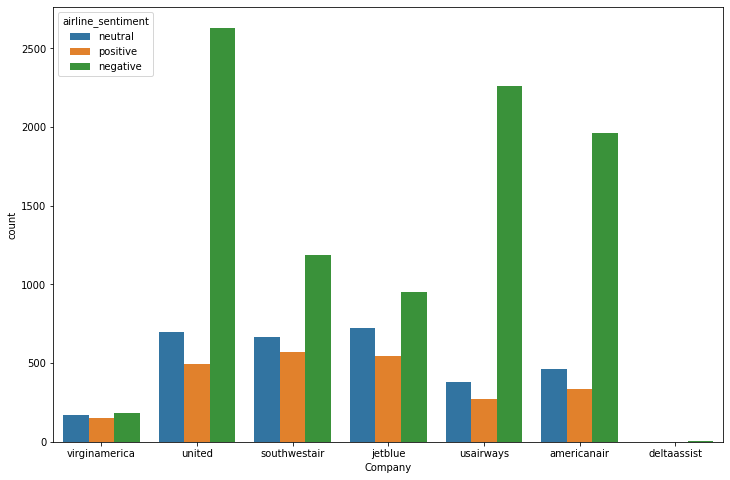

In [26]:
# Visualize sentiment count by airline -- United, USairways and Americanair have a lot of negative comments, VirginAmerica is pretty evenly distributed
plt.figure(figsize=(12, 8))
sns.countplot(x='Company', hue="airline_sentiment", data=tweets_df)

In [29]:
# Function to clean the tweets comments on each section below
wordlemmatizer = WordNetLemmatizer()
pattern = r'[^a-zA-z.,!?/:;\"\'\s]'
pattern_whitespace = r'^\s*|\s\s*'
stoplist = stopwords.words('english')
stoplist.remove('not')
stoplist.remove('ain')

def review_to_words(raw_review):

    # Remove HTML
    bsoup = BeautifulSoup(raw_review,'html.parser')
    no_html = bsoup.get_text() 

    # Convert emoji into text -- not in instructions but thought it might be fun to do
    no_emoji = demoji.replace_with_desc(no_html, sep=' ')
   
    # Remove company
    #no_company = re.sub(r'^@\w+','', no_html)

    # Remove http links
    no_links = re.sub(r'http\S+','', no_emoji)
  
    # Remove Punctuation
    no_punct = "".join([c for c in no_links if c not in string.punctuation])
   
    # Expand Contractions
    no_contratictions = contractions.fix(no_punct)
    
    # Convert to lower case
    no_upper = no_contratictions.lower()
 
    # Remove accents
    no_accent = unicodedata.normalize('NFKD', no_upper).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  
    # Removing special characters and numbers
    no_special = re.sub(pattern, '', no_accent)
  
    # Removing white space and tabs
    #no_space = re.sub(pattern_whitespace, ' ', no_special).strip()

    # Remove aa or one a 
    no_aa = re.sub(r'aa\s', '', no_special)
    no_aa = re.sub(r'aa', 'a', no_aa)
   
    # Tokenize
    no_token = word_tokenize(no_aa)
   
    # Remove Stopwords
    no_stop = [x for x in no_token if x not in stoplist]
   
    # Lemmatize
    no_lem = [lemma(wd) for wd in no_stop]
 
    # Joining it all back together to text
    return_value = " ".join(no_lem)

    return  return_value     
   
  

In [31]:
# Calling the cleaning function per tweet row
tweets_df.drop(['Company'], axis=1, inplace=True)
tweets_df['text'] = tweets_df['text'].apply(lambda x: review_to_words(x))
tweets_df.head() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,text,airline_sentiment
0,virginamerica dhepburn say,neutral
1,virginamerica plu add commercial experience tacky,positive
2,virginamerica not today must mean need take another trip,neutral
3,virginamerica really aggressive blast obnoxiou entertainment guest face little recourse,negative
4,virginamerica really big bad thing,negative


In [32]:
# Saving the result to examine
tweets_df.to_html("/content/drive/My Drive/NLP/test.html")

In [34]:
# Creating a list of words
num_sentiments = tweets_df["text"].size
clean_tweets = []
for i in range( 0, num_sentiments ):
   clean_tweets.append(tweets_df["text"][i]) 

In [35]:
# Creating the Term Frequency count Vectorizer
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 1000, ngram_range=(1,2))
train_data_features = vectorizer.fit_transform(clean_tweets)
train_data_features = train_data_features.toarray()

In [36]:
# Words in the vocabulary
vocab = vectorizer.get_feature_names()
print (vocab)

['able', 'able get', 'absolutely', 'accept', 'access', 'accommodate', 'account', 'actually', 'add', 'address', 'afternoon', 'agent', 'ago', 'air', 'aircraft', 'airline', 'airline ever', 'airplane', 'airport', 'airway', 'allow', 'almost', 'almost hour', 'already', 'also', 'alway', 'amaze', 'american', 'americanair', 'americanair call', 'americanair cancel', 'americanair flight', 'americanair get', 'americanair need', 'americanair not', 'americanair please', 'americanair still', 'americanair thank', 'americanair try', 'americanair usairway', 'americanair would', 'americanair ye', 'americanairline', 'angry', 'announce', 'another', 'another airline', 'another flight', 'answer', 'answer phone', 'anymore', 'anyone', 'anythe', 'anyway', 'anywhere', 'apology', 'app', 'apparently', 'apply', 'appreciate', 'area', 'around', 'arrival', 'arrive', 'ask', 'assist', 'assistance', 'atl', 'atlanta', 'attempt', 'attendant', 'attitude', 'austin', 'automate', 'available', 'award', 'away', 'awesome', 'awful

In [37]:
# Sum up the counts of each vocabulary word stopped at count of 12 to save processing time
dist = np.sum(train_data_features, axis=0)
for tag, count in zip(vocab, dist):
    print (count, tag)
    if count == 53:
      break

121 able
27 able get
30 absolutely
32 accept
39 access
26 accommodate
80 account
86 actually
126 add
54 address
30 afternoon
416 agent
130 ago
141 air
33 aircraft
553 airline
33 airline ever
84 airplane
366 airport
89 airway
88 allow
95 almost
26 almost hour
179 already
133 also
109 alway
101 amaze
79 american
2958 americanair
27 americanair call
41 americanair cancel
131 americanair flight
44 americanair get
37 americanair need
160 americanair not
29 americanair please
26 americanair still
160 americanair thank
63 americanair try
28 americanair usairway
26 americanair would
39 americanair ye
28 americanairline
26 angry
29 announce
272 another
28 another airline
46 another flight
189 answer
44 answer phone
27 anymore
114 anyone
135 anythe
29 anyway
27 anywhere
65 apology
113 app
38 apparently
30 apply
159 appreciate
30 area
63 around
34 arrival
154 arrive
165 ask
27 assist
53 assistance


In [38]:
# Creating training and testing set
le = LabelEncoder()
tweets_df['encoded'] = le.fit_transform(tweets_df['airline_sentiment'])
Y = tweets_df['encoded']
XC_train, XC_test, yc_train, yc_test = train_test_split(train_data_features, Y, test_size=0.3, random_state=0, stratify=Y) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
oversample = SMOTE()
XC_train, yc_train = oversample.fit_resample(XC_train, yc_train)  


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [40]:
from collections import Counter
counter = Counter(yc_train)
print(counter)

Counter({2: 6425, 0: 6425, 1: 6425})


In [41]:
# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(verbose=2,n_jobs=1,n_estimators = 100, criterion='gini') 
print ("Training the random forest...")
forest = forest.fit( XC_train, yc_train )
print (forest)
# Printing score
print (np.mean(cross_val_score(forest,XC_train,yc_train,cv=10)))

Training the random forest...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   25.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                       oob_score=False, random_state=None, verbose=2,
                       warm_start=False)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   22.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   22.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   23.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   22.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   22.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   22.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   22.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   22.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   22.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   22.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


0.7670630502985528


In [42]:
# Predicting and creating the confusion matrix and scores
predictions = forest.predict(XC_test)
 
cm = confusion_matrix(yc_test,predictions) 
print(cm)  
print(classification_report(yc_test,predictions))  
print(accuracy_score(yc_test, predictions))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


[[2230  353  170]
 [ 318  466  146]
 [ 128  132  449]]
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      2753
           1       0.49      0.50      0.50       930
           2       0.59      0.63      0.61       709

    accuracy                           0.72      4392
   macro avg       0.64      0.65      0.64      4392
weighted avg       0.72      0.72      0.72      4392

0.7160746812386156


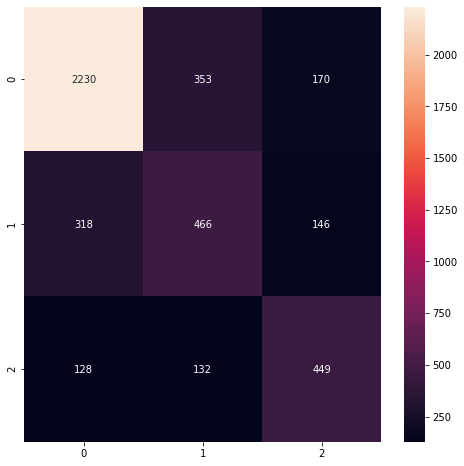

In [43]:
# Confusion matrix as heatmap
df_cm = pd.DataFrame(cm, index = [i for i in range(3)],
                     columns = [i for i in range(3)])
plt.figure(figsize = (8,8))
sns.heatmap(df_cm, annot=True, fmt='d')

In [44]:
# # Compare actual to predicted values -- model is performing well -- 2 wrong
picarr = [0, 59, 89,1234,700]

for i in picarr:
  print(f"Predict {i}: {predictions[i]}")
  print(f"Actual {i}: {yc_test.iloc[i]}")  

Predict 0: 0
Actual 0: 0
Predict 59: 0
Actual 59: 0
Predict 89: 0
Actual 89: 1
Predict 1234: 1
Actual 1234: 1
Predict 700: 0
Actual 700: 1


In [46]:
# Creating TF IDF Vectorizer and printing distribution
tfidfconverter = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.7,ngram_range=(1,2))  
X = tfidfconverter.fit_transform(clean_tweets)
df = pd.DataFrame(X[0].T.todense(), index=tfidfconverter.get_feature_names(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head(5000))

                 TF-IDF
say            0.713425
virginamerica  0.700732
able           0.000000
policy         0.000000
pout face      0.000000
...                 ...
forget         0.000000
form           0.000000
forward        0.000000
four           0.000000
zero           0.000000

[1000 rows x 1 columns]


In [47]:
# Creating training and testing set
  
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0, stratify=Y) 

In [48]:
# Upsampling
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [49]:
# Running RandomForest Classifier and training the model, displaying the score
text_classifier = RandomForestClassifier(verbose=2,n_jobs=1,n_estimators = 100, criterion='gini')  
text_classifier.fit(X_train, y_train)
print (np.mean(cross_val_score(text_classifier,X_train,y_train,cv=10)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   16.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


0.884679440663039


In [50]:
# Predicting and creating the confusion matrix and scores
prediction = text_classifier.predict(X_test)
 

cm = confusion_matrix(y_test,prediction) 
print(cm)  
print(classification_report(y_test,prediction))  
print(accuracy_score(y_test, prediction))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


[[2388  256  109]
 [ 357  477   96]
 [ 130  135  444]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      2753
           1       0.55      0.51      0.53       930
           2       0.68      0.63      0.65       709

    accuracy                           0.75      4392
   macro avg       0.69      0.67      0.68      4392
weighted avg       0.75      0.75      0.75      4392

0.7534153005464481


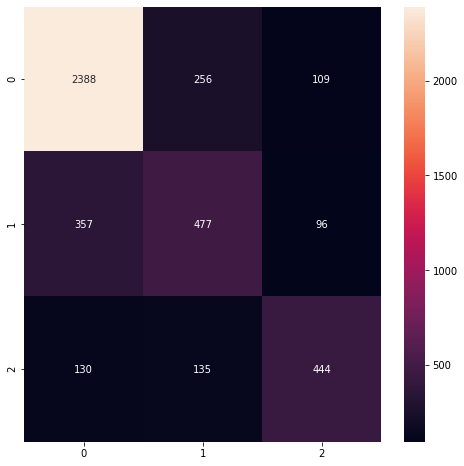

In [51]:
# Confusion matrix as heatmap
df_cm = pd.DataFrame(cm, index = [i for i in range(3)],
                     columns = [i for i in range(3)])
plt.figure(figsize = (8,8))
sns.heatmap(df_cm, annot=True, fmt='d')

In [52]:
# # Compare actual to predicted values -- model is performing well -- 2 wrong
picarr = [0, 59, 89,1234,700]

for i in picarr:
  print(f"Predict {i}: {prediction[i]}")
  print(f"Actual {i}: {yc_test.iloc[i]}")

Predict 0: 0
Actual 0: 0
Predict 59: 0
Actual 59: 0
Predict 89: 0
Actual 89: 1
Predict 1234: 1
Actual 1234: 1
Predict 700: 0
Actual 700: 1


Please look at my comments in each cell for documentation

It seems that from an accuracy score perspective TF IDF is performing slightly better at ~76% vs ~71%. This holds true for the other scores as well.

The diagonal in the confusion matrix shows the correct predictions.

0 = negative, 1 = neutral and 2 = positive

So for example 2558 tweets were predicted as negative comments and they were actually negative comments or 380 comments were predicted positive and they were positive.

Overall people are not to happy with their airlines, looking at the countplot UsAir, United and American have a lot of unhappy customers.

Virginair seems to have as manny neutral or negative comments as they have positive comments.



I did some extra work to use a DNN model. I know this was not in the instructions but wanted to try it

In [62]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
from keras.layers import Bidirectional

In [63]:
# convert airline_seentiment to numeric
sentiment_label = tweets_df.airline_sentiment.factorize()
sentiment_label

(array([0, 1, 0, ..., 0, 2, 0]),
 Index(['neutral', 'positive', 'negative'], dtype='object'))

In [64]:
# Created a padded vector
max_fatures = 5000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(tweets_df['text'].values)
X = tokenizer.texts_to_sequences(tweets_df['text'].values)
X = pad_sequences(X)
print(tokenizer.word_index)
print(X[0])

{'flight': 1, 'unite': 2, 'not': 3, 'usairway': 4, 'americanair': 5, 'southwestair': 6, 'jetblue': 7, 'get': 8, 'thank': 9, 'hour': 10, 'cancel': 11, 'service': 12, 'delay': 13, 'time': 14, 'help': 15, 'customer': 16, 'go': 17, 'fly': 18, 'call': 19, 'bag': 20, 'u': 21, 'wait': 22, 'plane': 23, 'hold': 24, 'make': 25, 'need': 26, 'would': 27, 'try': 28, 'one': 29, 'still': 30, 'please': 31, 'day': 32, 'airline': 33, 'gate': 34, 'back': 35, 'virginamerica': 36, 'flightle': 37, 'seat': 38, 'take': 39, 'say': 40, 'book': 41, 'tell': 42, 'face': 43, 'change': 44, 'phone': 45, 'know': 46, 'check': 47, 'like': 48, 'hr': 49, 'late': 50, 'today': 51, 'guy': 52, 'agent': 53, 'work': 54, 'miss': 55, 'ticket': 56, 'give': 57, 'min': 58, 'airport': 59, 'can': 60, 'way': 61, 'minute': 62, 'board': 63, 'want': 64, 'see': 65, 'great': 66, 'sit': 67, 'lose': 68, 'even': 69, 'send': 70, 'never': 71, 'last': 72, 'tomorrow': 73, 'love': 74, 'problem': 75, 'weather': 76, 'really': 77, 'good': 78, 'new': 7

In [65]:
# Creating the model
model = Sequential()
model.add(Embedding(max_fatures, 128, input_length = X.shape[1],))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(196, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(512, activation='relu'))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 86, 128)           640000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 86, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 392)               509600    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               201216    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 1,352,355
Trainable params: 1,352,355
Non-trainable params: 0
_________________________________________________________________
None


In [66]:
# Creating train test data
Y = pd.get_dummies(tweets_df['airline_sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(10248, 86) (10248, 3)
(4392, 86) (4392, 3)


In [68]:
# Fitting the data
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=8)
checkpoint1 = ModelCheckpoint("/content/drive/My Drive/NLP/best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model.fit(X_train,Y_train, validation_split=0.2, epochs=20, batch_size=32,callbacks=[checkpoint1, early_stop], verbose=2)

Epoch 1/20
257/257 - 233s - loss: 0.1742 - accuracy: 0.9358 - val_loss: 0.8538 - val_accuracy: 0.7454

Epoch 00001: val_accuracy improved from -inf to 0.74537, saving model to /content/drive/My Drive/NLP/best_model1.hdf5
Epoch 2/20
257/257 - 232s - loss: 0.1506 - accuracy: 0.9444 - val_loss: 0.9269 - val_accuracy: 0.7483

Epoch 00002: val_accuracy improved from 0.74537 to 0.74829, saving model to /content/drive/My Drive/NLP/best_model1.hdf5
Epoch 3/20
257/257 - 232s - loss: 0.1350 - accuracy: 0.9502 - val_loss: 0.9604 - val_accuracy: 0.7483

Epoch 00003: val_accuracy did not improve from 0.74829
Epoch 4/20
257/257 - 233s - loss: 0.1260 - accuracy: 0.9533 - val_loss: 0.9282 - val_accuracy: 0.7546

Epoch 00004: val_accuracy improved from 0.74829 to 0.75463, saving model to /content/drive/My Drive/NLP/best_model1.hdf5
Epoch 5/20
257/257 - 231s - loss: 0.1096 - accuracy: 0.9586 - val_loss: 1.1220 - val_accuracy: 0.7527

Epoch 00005: val_accuracy did not improve from 0.75463
Epoch 6/20
257/

In [69]:
# Load best model and evaluate 
model.load_weights("/content/drive/My Drive/NLP/best_model1.hdf5")
eval_results = model.evaluate(X_test, Y_test)
print("[test loss, test accuracy]:", eval_results)

138/138 [==============================] - 17s 121ms/step - loss: 1.3856 - accuracy: 0.7589
[test loss, test accuracy]: [1.3855503797531128, 0.7588797807693481]


In [70]:
# Predicting and displaying the confusion matrix
Y_pred = model.predict_classes(X_test)
rounded_labels=np.argmax(Y_test, axis=1)
cm = confusion_matrix(rounded_labels, Y_pred)
print(cm)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[2497  226   91]
 [ 374  402  108]
 [ 168   92  434]]


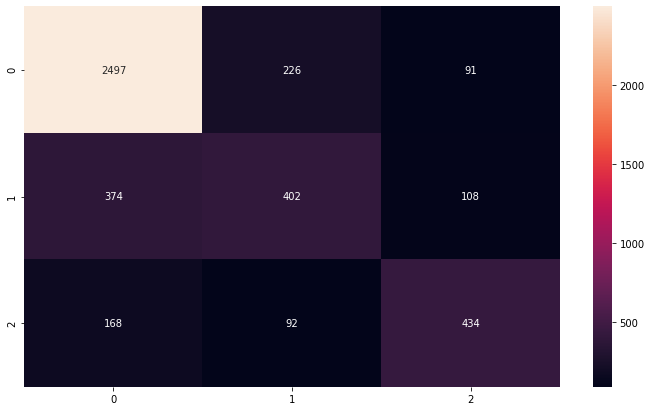

In [71]:
df_cm = pd.DataFrame(cm, index = [i for i in range(3)],
                     columns = [i for i in range(3)])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, fmt='d')

In [72]:
# Printing the classification report
print("=== Classification Report ===")
print(classification_report(rounded_labels, Y_pred))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      2814
           1       0.56      0.45      0.50       884
           2       0.69      0.63      0.65       694

    accuracy                           0.76      4392
   macro avg       0.69      0.66      0.67      4392
weighted avg       0.75      0.76      0.75      4392



In [73]:
# Compare actual to predicted values -- model is performing well -- 1 wrong
picarr = [0,50,44,55,100,45]

for i in picarr:
  print(f"Predict {i}: {Y_pred[i]}")
  print(f"Actual {i}: {np.argmax(Y_test[i])}")

Predict 0: 2
Actual 0: 2
Predict 50: 1
Actual 50: 1
Predict 44: 1
Actual 44: 1
Predict 55: 0
Actual 55: 2
Predict 100: 0
Actual 100: 0
Predict 45: 2
Actual 45: 2
